In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt

In [51]:
# 模拟数据获取
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[108.128234,33.2141348,10000],[110.86143245,35.750012,10000],180,0)
receiver1 = Receiver([108.7187911987,34.0290298462,435],dirfting=-500,NoiseRange=(0,0))
receiver2 = Receiver([108.7135726929,34.0363121033,427],dirfting=500,NoiseRange=(0,0))
# receiver3 = Receiver([118.56588,34.448925,500])
time_track1 =receiver1.fin_time_track(airplane1)
time_track2 =receiver2.fin_time_track(airplane1)
# time_track3 =receiver3.fin_time_track(airplane1)
track = airplane1.track
print(len(track))

4328


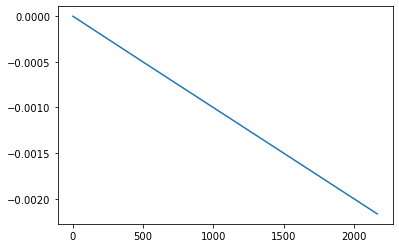

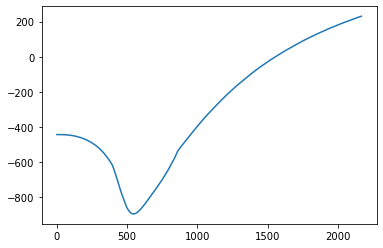

In [52]:
# 预处理step1
# 获取TDOA DDOA
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan

TDOA_12 = [] #到达时间差
DDOA_12 = [] #距离差
time_line = time_track1


for i in range(len(track)):
    TDOA_12.append(time_track1[i] - time_track2[i])
    DDOA_12.append(airplane1.geodistance(track[i],receiver1.location)-airplane1.geodistance(track[i],receiver2.location))
    

# plt.plot(using_data[19:79], test_data[19:79])
plt.plot(time_line, TDOA_12)
plt.show()
# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)
plt.plot(time_line, DDOA_12)
plt.show()


In [61]:
# 预处理step3
# 训练集数据归一化，并化为cuda类型
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

TDOA_array = np.array(TDOA_12)
TDOA_norm = sc.fit_transform(TDOA_array.reshape(-1,1))
TDOA_norm = torch.FloatTensor(TDOA_norm).view(-1)
print(TDOA_norm[0:10])

lng = []
lat = []
alt = []

for position in track:
    lng.append(position[0])
    lat.append(position[1])
    alt.append(position[2])

lng_array = np.array(lng)
lng_norm = sc.fit_transform(lng_array.reshape(-1,1))


lat_array = np.array(lat)
lat_norm = sc.fit_transform(lat_array.reshape(-1,1))

alt_array = np.array(alt)
alt_norm = sc.fit_transform(alt_array.reshape(-1,1))

track_norm = [] #归一化轨迹列表
x_data = []
for i in range(1,len(lng_norm)):
    track_norm.append([lng_norm[i][0],lat_norm[i][0], alt_norm[i][0]])
    x_data.append([lng_norm[i-1][0],lat_norm[i-1][0], alt_norm[i-1][0], TDOA_norm[i]])
    
print(track_norm[:10])

tensor([1.0000, 0.9996, 0.9991, 0.9987, 0.9982, 0.9976, 0.9972, 0.9968, 0.9963,
        0.9959])
[[-0.9995606797279919, -0.9993227427357034, 0.9986927497370104], [-0.9991213594559838, -0.9986459851585217, 0.99738627239417], [-0.9986820391839899, -0.9979697270704797, 0.9960805668485051], [-0.9982427189119818, -0.997293968273528, 0.9947756319770598], [-0.9978033986399737, -0.9966187085696312, 0.9934714666568638], [-0.9973640783679798, -0.995943947760793, 0.9921680697649613], [-0.9969247580959717, -0.9952696856489744, 0.9908654401783892], [-0.9964854378239778, -0.9945959220361544, 0.9895635767741808], [-0.9960461175519555, -0.9939226567242834, 0.9882624784293697], [-0.9956067972799616, -0.9932498895153756, 0.9869621440210068]]


In [62]:
# 预处理step2
# 划分训练集和测试集

x_data = np.array(x_data[:3000])
y_data = np.array(track_norm[:3000])
print(x_data[0:10])
print(y_data[0:10])

test_size = 1000

x_train_set = x_data[: -test_size]
x_test_set = x_data[-test_size:]

y_train_set = y_data[: -test_size]
y_test_set = y_data[-test_size:]

[[-1.         -1.          1.          0.99960095]
 [-0.99956068 -0.99932274  0.99869275  0.99911082]
 [-0.99912136 -0.99864599  0.99738627  0.99872535]
 [-0.99868204 -0.99796973  0.99608057  0.99818176]
 [-0.99824272 -0.99729397  0.99477563  0.9976334 ]
 [-0.9978034  -0.99661871  0.99347147  0.99718475]
 [-0.99736408 -0.99594395  0.99216807  0.99679863]
 [-0.99692476 -0.99526969  0.99086544  0.99626237]
 [-0.99648544 -0.99459592  0.98956358  0.99588019]
 [-0.99604612 -0.99392266  0.98826248  0.99546325]]
[[-0.99956068 -0.99932274  0.99869275]
 [-0.99912136 -0.99864599  0.99738627]
 [-0.99868204 -0.99796973  0.99608057]
 [-0.99824272 -0.99729397  0.99477563]
 [-0.9978034  -0.99661871  0.99347147]
 [-0.99736408 -0.99594395  0.99216807]
 [-0.99692476 -0.99526969  0.99086544]
 [-0.99648544 -0.99459592  0.98956358]
 [-0.99604612 -0.99392266  0.98826248]
 [-0.9956068  -0.99324989  0.98696214]]


In [64]:
# 预处理step4
# 将数据处理为lstm接受的类型
x_train = x_train_set.reshape(-1, 1, 4) #将训练数据调整成pytorch中lstm算法的输入维度
y_train = y_train_set.reshape(-1, 1, 3)  #将目标值调整成pytorch中lstm算法的输出维度

 #将ndarray数据转换为张量，因为pytorch用的数据类型是张量

x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()

print(x_train)

tensor([[[-1.0000, -1.0000,  1.0000,  0.9996]],

        [[-0.9996, -0.9993,  0.9987,  0.9991]],

        [[-0.9991, -0.9986,  0.9974,  0.9987]],

        ...,

        [[ 0.0788, -0.2995, -0.9974,  0.0759]],

        [[ 0.0792, -0.2991, -0.9975,  0.0754]],

        [[ 0.0796, -0.2988, -0.9975,  0.0748]]], device='cuda:0',
       dtype=torch.float64)


In [65]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__() #面向对象中的继承
        self.lstm = nn.LSTM(4,60,2) #输入数据1个特征维度，6个隐藏层维度，2个LSTM串联，第二个LSTM接收第一个的计算结果
        self.out = nn.Linear(60,3) #线性拟合，接收数据的维度为6，输出数据的维度为3
    def forward(self,x):
        x1,_ = self.lstm(x)
        a,b,c = x1.shape
        out = self.out(x1.view(-1,c)) #因为线性层输入的是个二维数据，所以此处应该将lstm输出的三维数据x1调整成二维数据，最后的特征维度不能变
        out1 = out.view(a,b,-1) #因为是循环神经网络，最后的时候要把二维的out调整成三维数据，下一次循环使用
        return out1

rnn = RNN().cuda()

#参数寻优，计算损失函数

optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss()

In [66]:
for i in range(300):
    var_x = Variable(x_train).type(torch.FloatTensor).cuda()
    var_y = Variable(y_train).type(torch.FloatTensor).cuda()
    out = rnn(var_x)
    loss = loss_func(out,var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1)%10==0:
        print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))
        
#         pred = rnn(var_dataX)
#         pred_test = pred.view(-1,3).cpu().data.numpy()
#         plt.plot(pred_test[:,0],pred_test[:,1], 'r.', label='prediction')
#         plt.plot(y_data[:,0],y_data[:,1], 'b.', label='real')
#         plt.show()

Epoch:10, Loss:0.02297
Epoch:20, Loss:0.00491
Epoch:30, Loss:0.00157
Epoch:40, Loss:0.00072
Epoch:50, Loss:0.00038
Epoch:60, Loss:0.00024
Epoch:70, Loss:0.00016
Epoch:80, Loss:0.00013
Epoch:90, Loss:0.00011
Epoch:100, Loss:0.00009
Epoch:110, Loss:0.00008
Epoch:120, Loss:0.00007
Epoch:130, Loss:0.00006
Epoch:140, Loss:0.00005
Epoch:150, Loss:0.00005
Epoch:160, Loss:0.00004
Epoch:170, Loss:0.00004
Epoch:180, Loss:0.00003
Epoch:190, Loss:0.00003
Epoch:200, Loss:0.00003
Epoch:210, Loss:0.00002
Epoch:220, Loss:0.00002
Epoch:230, Loss:0.00002
Epoch:240, Loss:0.00002
Epoch:250, Loss:0.00002
Epoch:260, Loss:0.00002
Epoch:270, Loss:0.00001
Epoch:280, Loss:0.00001
Epoch:290, Loss:0.00001
Epoch:300, Loss:0.00001


In [74]:
dataX1 = x_data.reshape(-1,1,4)
dataX2 = torch.from_numpy(dataX1)
var_dataX = Variable(dataX2).type(torch.FloatTensor).cuda()
rnn.eval()

pred = rnn(var_dataX[-test_size:])

pred_test = pred.view(-1,3).cpu().data.numpy()  #转换成一维的ndarray数据，这是预测值

In [75]:
print(len(pred_test), len(y_data))

1000 3000


In [79]:
print(var_dataX[2500:2510])
print(pred[500:510])

tensor([[[ 0.2777, -0.0941, -0.9047, -0.1568]],

        [[ 0.2781, -0.0937, -0.9042, -0.1574]],

        [[ 0.2785, -0.0932, -0.9038, -0.1578]],

        [[ 0.2789, -0.0928, -0.9034, -0.1582]],

        [[ 0.2793, -0.0923, -0.9030, -0.1587]],

        [[ 0.2796, -0.0919, -0.9025, -0.1593]],

        [[ 0.2800, -0.0914, -0.9021, -0.1598]],

        [[ 0.2804, -0.0910, -0.9017, -0.1603]],

        [[ 0.2808, -0.0905, -0.9012, -0.1608]],

        [[ 0.2812, -0.0901, -0.9008, -0.1613]]], device='cuda:0')
tensor([[[ 0.2126, -0.1518, -1.0434]],

        [[ 0.2128, -0.1516, -1.0434]],

        [[ 0.2130, -0.1514, -1.0434]],

        [[ 0.2132, -0.1512, -1.0434]],

        [[ 0.2134, -0.1510, -1.0434]],

        [[ 0.2135, -0.1508, -1.0434]],

        [[ 0.2137, -0.1506, -1.0434]],

        [[ 0.2139, -0.1504, -1.0434]],

        [[ 0.2141, -0.1502, -1.0434]],

        [[ 0.2143, -0.1499, -1.0434]]], device='cuda:0',
       grad_fn=<SliceBackward>)


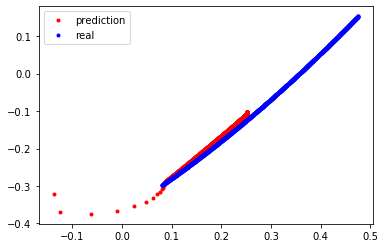

In [76]:
plt.plot(pred_test[:,0],pred_test[:,1], 'r.', label='prediction')
plt.plot(y_data[-test_size:,0],y_data[-test_size:,1], 'b.', label='real')
plt.legend(loc='best')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(pred_test[:,0],pred_test[:,1], pred_test[:,2], 'r.', label='prediction')
ax.plot(y_data[:,0],y_data[:,1], y_data[:,2], 'b.', label='real')
ax.legend(loc='best')

In [114]:
dataX = np.array(dataX)
print(dataX[:,0])

[0.01204819 0.02409639 0.54216867 0.93975904 0.04819277 0.09638554
 0.08433735 0.01204819 0.09638554 0.08433735 0.04819277 0.08433735
 0.04819277 0.08433735 0.01204819 0.08433735 0.06024096 0.01204819
 0.08433735 0.06024096 0.04819277 0.08433735 0.06024096 0.04819277
 0.08433735 0.06024096 0.04819277 0.08433735 0.09638554 0.06024096
 0.09638554 0.10843373 0.07228916 0.08433735 0.09638554 0.06024096
 0.08433735 0.09638554 0.06024096 0.09638554 0.10843373 0.06024096
 0.04819277 0.08433735 0.06024096 0.08433735 0.10843373 0.06024096
 0.89156627 0.04819277 0.09638554 0.06024096 0.08433735 1.01204819
 0.08433735 0.09638554 0.89156627]
